In [9]:
import random
import time
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [10]:
def getCameraParams ( isColor: bool ) :
    # TODO : consider distortion

    # RGB Intrinsic Parameters
    fx_rgb = 5.1885790117450188e+02
    fy_rgb = 5.1946961112127485e+02
    cx_rgb = 3.2558244941119034e+02
    cy_rgb = 2.5373616633400465e+02
    # # RGB Distortion Parameters
    # k1_rgb =  2.0796615318809061e-01
    # k2_rgb = -5.8613825163911781e-01
    # k3_rgb = 4.9856986684705107e-01
    # p1_rgb = 7.2231363135888329e-04
    # p2_rgb = 1.0479627195765181e-03

    # Depth Intrinsic Parameters
    fx_d = 5.8262448167737955e+02
    fy_d = 5.8269103270988637e+02
    cx_d = 3.1304475870804731e+02
    cy_d = 2.3844389626620386e+02
    # # RGB Distortion Parameters
    # k1_d = -9.9897236553084481e-02
    # k2_d = 3.9065324602765344e-01
    # k3_d = -5.1031725053400578e-01
    # p1_d = 1.9290592870229277e-03
    # p2_d = -1.9422022475975055e-03

    if isColor :
        return cx_rgb, cy_rgb, fx_rgb, fy_rgb
    return cx_d, cy_d, fx_d, fy_d

In [11]:
img_idx = "3"

root_dir = "../nyudv2"
# image = cv2.imread(f"{root_dir}/rgb_{img_idx}.png")
# image_depth = np.mean(cv2.imread(f"{root_dir}/depth_{img_idx}.png"), axis=2)
# image_labelmaps = cv2.imread(f"{root_dir}/label_maps_{img_idx}.png")
image = np.load(f"{root_dir}/rgb/{img_idx}.npy")
image_depth = np.load(f"{root_dir}/depth/{img_idx}.npy")
image_labelmaps = np.load(f"{root_dir}/label/{img_idx}.npy")

image_hha = cv2.imread(f"{root_dir}/hha/{img_idx}.png")

In [12]:
print(image.shape)
print(image_depth.shape)
print(image_labelmaps.shape)
print(image_hha.shape)

(480, 640, 3)
(480, 640)
(480, 640)
(480, 640, 3)


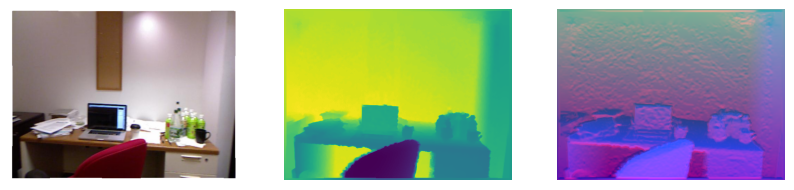

In [13]:
_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image)
subplts[0].axis('off')
subplts[1].imshow(image_depth)
subplts[1].axis('off')
subplts[2].imshow(image_hha)
subplts[2].axis('off')
plt.show()

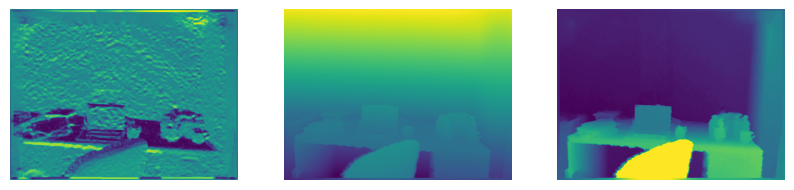

In [14]:
_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image_hha[:, :, 0])
subplts[0].axis('off')
subplts[1].imshow(image_hha[:, :, 1])
subplts[1].axis('off')
subplts[2].imshow(image_hha[:, :, 2])
subplts[2].axis('off')
plt.show()

In [15]:
image_xyz = np.zeros((image_depth.shape[0], image_depth.shape[1], 3))
height, width = image_depth.shape
CX_DEPTH, CY_DEPTH, FX_DEPTH, FY_DEPTH = getCameraParams(isColor=False)
for i in range(height):
   for j in range(width):
       z = image_depth[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       image_xyz[i][j] = [x, y, z]

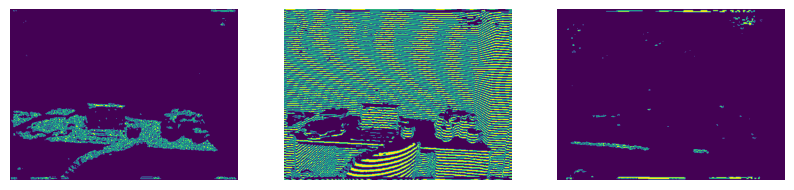

In [16]:
down = image_hha[:, :, 0] < 255/3
horiz = ( 255/3 <= image_hha[:, :, 0] ) & ( image_hha[:, :, 0] < 2*255/3 )
up = 2*255/3 <= image_hha[:, :, 0]

_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image_hha[:, :, 0] & down)
subplts[0].axis('off')
subplts[1].imshow(image_hha[:, :, 1] & horiz)
subplts[1].axis('off')
subplts[2].imshow(image_hha[:, :, 2] & up)
subplts[2].axis('off')
plt.show()

In [17]:
image_lmasks = [ image_labelmaps == label for label in np.unique(image_labelmaps) if label != 0 ] # 0 is background

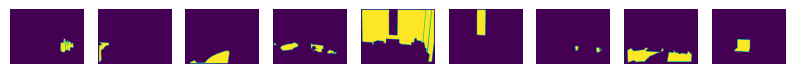

In [18]:
_, subplts = plt.subplots(1, len(image_lmasks), figsize=(10, 10))
for i, imask in enumerate(image_lmasks) :
    subplts[i].imshow(imask)
    subplts[i].axis('off')
plt.show()

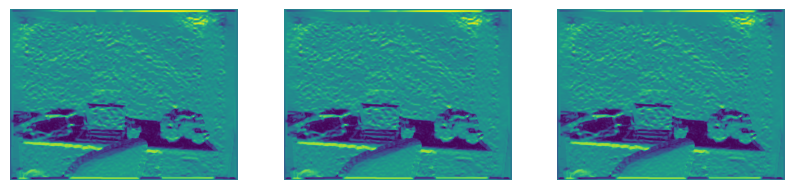

In [19]:
_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image_hha[:, :, 0])
subplts[0].axis('off')
subplts[1].imshow(image_hha[:, :, 0])
subplts[1].axis('off')
subplts[2].imshow(image_hha[:, :, 0])
subplts[2].axis('off')
plt.show()

In [20]:
needFast = False

In [21]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.addImage(image_hha)
if needFast :
	print("[INFO] using *fast* selective search")
	ss.switchToSelectiveSearchFast()
else:
	print("[INFO] using *quality* selective search")
	ss.switchToSelectiveSearchQuality()

[INFO] using *quality* selective search


In [22]:
# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()
# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))

[INFO] selective search took 9.2412 seconds
[INFO] 6594 total region proposals


In [23]:
bocses_per = 30
for i in range(0, len(rects), bocses_per):
	output = image.copy()
	for (x, y, w, h) in rects[i:i + bocses_per]:
		color = [random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
	cv2.imshow("Output", output)
	key = cv2.waitKey(0) & 0xFF
	if key == ord("q"):
		break
cv2.destroyWindow("Output")

In [24]:
def ground_truth_is_region_good ( rect ) :
    score = 0
    x, y, w, h = rect
    for mask in image_lmasks :
        mask_region = mask[y:y+h, x:x+w]
        # using jaccard similarity as per the paper
        sim = np.sum(mask_region) / ( np.sum(mask) + w*h - np.sum(mask_region) )
        if sim > score :
            score = sim
    return score > 0.5 # return whether this region is good or not

In [25]:
candidates = []
min_region_size = 30

X, Y = list(), list()
for (x, y, w, h) in rects:
    # check if the proposed box is too small
    if w < min_region_size or h < min_region_size:
        continue

    proposed_box_rgb = image[y:y+h, x:x+w]
    proposed_box_depth = image_depth[y:y+h, x:x+w]
    proposed_box_angle = image_hha[y:y+h, x:x+w][:, :, 0]
    proposed_box_height = image_hha[y:y+h, x:x+w][:, :, 1]
    proposed_box_disparity = image_hha[y:y+h, x:x+w][:, :, 2]
    proposed_box_xyz = image_xyz[y:y+h, x:x+w].reshape(-1, 3)

    depth_mean_sd = np.mean(proposed_box_depth), np.std(proposed_box_depth)
    height_mean_sd = np.mean(proposed_box_height), np.std(proposed_box_height)
    angle_mean_sd = np.mean(proposed_box_angle), np.std(proposed_box_angle)
    disparity_mean_sd = np.mean(proposed_box_disparity), np.std(proposed_box_disparity)
    x_mean_sd = np.mean(proposed_box_xyz[:, 0]), np.std(proposed_box_xyz[:, 0])
    y_mean_sd = np.mean(proposed_box_xyz[:, 1]), np.std(proposed_box_xyz[:, 1])
    z_mean_sd = np.mean(proposed_box_xyz[:, 2]), np.std(proposed_box_xyz[:, 2])
    extent_x = np.max(proposed_box_xyz[:, 0]) - np.min(proposed_box_xyz[:, 0])
    extent_y = np.max(proposed_box_xyz[:, 1]) - np.min(proposed_box_xyz[:, 1])
    extent_z = np.max(proposed_box_xyz[:, 2]) - np.min(proposed_box_xyz[:, 2])
    min_height = np.min(proposed_box_height)
    max_height = np.max(proposed_box_height)
    frac_facing_down = np.sum(proposed_box_angle < 255/3) / (w*h)
    frac_facing_horiz = np.sum(( 255/3 <= proposed_box_angle ) & ( proposed_box_angle < 2*255/3 )) / (w*h)
    frac_facing_up = np.sum(2*255/3 <= proposed_box_angle) / (w*h)

    features = [ *depth_mean_sd, *height_mean_sd, *angle_mean_sd, *disparity_mean_sd, *x_mean_sd, *y_mean_sd, *z_mean_sd, extent_x, extent_y, extent_z, min_height, max_height, frac_facing_down, frac_facing_horiz, frac_facing_up ]
    X.append(features)
    Y.append(ground_truth_is_region_good((x, y, w, h)))
X = np.asanyarray(X)
Y = np.asanyarray(Y)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

In [27]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2893, 22)
(2893,)
(1241, 22)
(1241,)


In [28]:
clf = RandomForestClassifier(max_depth=2)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2)

In [29]:
#calculate train and test accuracy
print("Train Accuracy :: ", clf.score(X_train, Y_train))
print("Test Accuracy  :: ", clf.score(X_test, Y_test))

Train Accuracy ::  0.8240580712063602
Test Accuracy  ::  0.8420628525382756


In [ ]:
for box in np.argwhere(clf.predict(X_test) == 1).flatten():
    x, y, w, h = rects[box]
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imshow("Output", image)
	key = cv2.waitKey(0) & 0xFF
	if key == ord("q"):
		break
cv2.destroyWindow("Output")